In [9]:
import Pkg

Pkg.add("Interpolations")
Pkg.add("Plots")
Pkg.add("PyCall")
Pkg.add("OrdinaryDiffEq")
Pkg.add("YAML")
Pkg.add("DelimitedFiles")
Pkg.add("CSV")
Pkg.add("HDF5")
Pkg.add("StructArrays")
Pkg.add("Random")

using Interpolations, Plots, PyCall, OrdinaryDiffEq, YAML, DelimitedFiles, CSV, HDF5, StructArrays, Random
ct = pyimport("cantera")

#ENV["PYTHON"] = "/opt/conda/envs/lae2020/bin/python"
#Pkg.build("PyCall")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.t

PyObject <module 'cantera' from '/opt/conda/envs/lae2020/lib/python3.8/site-packages/cantera/__init__.py'>

In [10]:
using YAML

In [11]:

"Composite type to hold ambient conditions, parameters and initial conditions"
struct AmbientConditions
    "Ambient velocity [m/s]"
    u_a::AbstractFloat
    "Ambient temperature [K]"
    T_a::AbstractFloat
    "Ambient passive tracer mixing ratio"
    χ_a::AbstractFloat
    "Prandtl number"
    Pr::AbstractFloat
    "Lewis number"
    Le::AbstractFloat
    "Specific gas constant of air [J/kg]"
    R::AbstractFloat
    "Ambient pressure [Pa]"
    p::AbstractFloat
    "Initial temperature [K]"
    T0::AbstractFloat
    "Initial velocity"
    u0::AbstractFloat
    "Initial passive tracer mixing ratio"
    χ0::AbstractFloat
end

"""
    second_order_central(x, i, Δ)
Computes the second order central difference approximation to the second
derivative of the variable x w.r.t. its discretization dimension (e.g. x is
the state, and its entries x[i] are the values for different radial dimensions)
using the step size Δ, at location i.
# Inputs
- `x` State vector
- `i` Index to compute second order difference for 
- 'Δ' The spacing between the vector elements
"""
function second_order_central(x::AbstractVector, i::Integer, Δ::AbstractFloat)
    return ((x[i+1] - 2 * x[i] + x[i-1]) / Δ^2)
end

"""
    construct_rhs(u, T, y, Δψ, Δϕ, ambient; χ=nothing)
Constructs the right-hand-side vector for the system `Ax=b` resulting
from applying the Crank-Nicholson scheme to the governing equations.
# Inputs 
- `u` axial velocities
- `T` temperature
- `y` y-locations of grid points 
- `Δψ` Spacing between grid points in ϕ-ψ space
- `Δϕ` Step size in ϕ-ψ space
- `ambient` Ambient conditions
- `χ` Mixing ratio of passive tracer
"""
function construct_rhs(u::AbstractVector, T::AbstractVector, y::AbstractVector,
    Δψ::AbstractVector, Δϕ::AbstractFloat, ambient::AmbientConditions;
    χ::AbstractVector=nothing)

    if χ !== nothing
        b = zeros(size(u)[1] + size(T)[1] + size(χ)[1])
        include_χ = true
    else
        b = zeros(size(u)[1] + size(T)[1])
        include_χ = false
    end

    ## Boundary conditions

    # Neumann conditions at y=0
    b[1] = 0.0
    b[size(u)[1]+1] = 0.0

    # Dirichlet conditions at y -> infinity 
    b[size(u)[1]] = ambient.u_a
    b[size(u)[1]+size(T)[1]] = ambient.T_a

    # Definition for convenience 
    λ = ambient.u0 / ((ambient.R / ambient.p)^2 * ambient.T0^2)
    Le = ambient.Le

    # Loop through b 
    for i = 2:size(u)[1]-1
        b[i] = u[i] / Δϕ + 0.5 * λ * y[i]^2 * second_order_central(u, i, Δψ[i])
        b[i+size(u)[1]] = (T[i] / Δϕ + 0.5 * λ * y[i]^2
                                       * second_order_central(T, i, Δψ[i]) / ambient.Pr)
    end

    if include_χ
        for i = 2:size(u)[1]-1
            b[i+2*size(u)[1]] = (χ[i] / Δϕ + Le * 0.5 * λ * y[i]^2
                                             * second_order_central(χ, i, Δψ[i]) / ambient.Pr)
        end
        b[size(u)[1]+size(T)[1]+1] = 0.0
        b[end] = ambient.χ_a
    end

    return b
end

"""
    construct_tridiagonal_matrix(n, Δψ, Δϕ, y, ambient; include_χ=false)
Constructs the matrix `A` for the system `Ax=b` resulting
from applying the Crank-Nicholson scheme to the governing equations.
# Inputs 
- `n` Number of grid points in radial direction
- `Δψ` Spacing between grid points in ϕ-ψ space
- `Δϕ` Step size in ϕ-ψ space
- `y` y-locations of grid points 
- `ambient` Ambient conditions
- `include_χ` indicates if passive tracer is simulated as well
"""
function construct_tridiagonal_matrix(n::Integer, Δψ::AbstractVector,
    Δϕ::AbstractFloat, y::AbstractVector, ambient::AmbientConditions;
    include_χ::Bool=false)

    if include_χ
        A = zeros((3 * n, 3 * n))
    else
        A = zeros((2 * n, 2 * n))
    end
    ## Boundary conditions 

    # Neumann conditions at y=0
    A[1, 1] = (-1 / (Δψ[1]))
    A[1, 2] = 1 / (Δψ[1])
    A[n+1, n+1] = -1 / Δψ[1]
    A[n+1, n+2] = 1 / Δψ[1]

    # Dirichlet conditions at y -> infinity 
    A[n, n] = 1.0
    A[2*n, 2*n] = 1.0

    # Definition for convenience 
    λ = ambient.u0 / ((ambient.R / ambient.p)^2 * ambient.T0^2)

    Pr = ambient.Pr
    Le = ambient.Le
    # Loop through matrix 
    for i = 2:n-1

        # For u 
        A[i, i] = 1 / Δϕ + λ * y[i]^2 / (Δψ[i]^2)
        A[i, i-1] = -λ * y[i]^2 / (2 * Δψ[i]^2)
        A[i, i+1] = -λ * y[i]^2 / (2 * Δψ[i]^2)

        # For T 
        j = i + n
        A[j, j] = 1 / Δϕ + λ * y[i]^2 / (Pr * Δψ[i]^2)
        A[j, j-1] = -λ * y[i]^2 / (2 * Pr * Δψ[i]^2)
        A[j, j+1] = -λ * y[i]^2 / (2 * Pr * Δψ[i]^2)
    end

    if include_χ
        A[2*n+1:end, 2*n+1:end] = Le .* A[n+1:2*n, n+1:2*n]
        A[2*n+1, 2*n+1] = -1 / Δψ[1]
        A[2*n+1, 2*n+2] = 1 / Δψ[1]
        A[3*n, 3*n] = 1.0
    end

    return A
end

"""
    compute_y(u, T, Δψ, R, p)
Computes y locations corresponding to particular states, based on the 
grid spacing in ϕ-ψ space. 
# Inputs 
- `u` axial velocities
- `T` temperature
- `Δψ` Spacing in ϕ-ψ space
- `R` Specific gas constant for air in J/kg
- `p` Ambient pressure in Pa
"""
function compute_y(u::AbstractVector, T::AbstractVector, Δψ::AbstractVector,
    R::AbstractFloat, p::AbstractFloat)
    return (2 * cumsum((R / p) * T ./ u) .* Δψ) .^ 0.5

end

"""
   compute_x(ϵ, Δϕ)
Computes x locations of the grid based on turbulent mixing coefficient ϵ
and step sizes Δϕ
# Inputs 
- `ϵ` Values of the turbulent mixing coefficient
- `Δϕ` Step sizes
"""
function compute_x(ϵ::AbstractVector, Δϕ::AbstractVector)
    x = zeros(size(ϵ))
    x[2:end] = cumsum(Δϕ[1:end-1] ./ ϵ[1:end-1])
    return x
end

"""
    compute_ψ(u, T, y, p, R)
Computes the transformed coordinate ψ based on the state and y locations.
# Inputs
- `u` axial velocities
- `T` temperature
- `y` y-locations of grid points 
- `R` Specific gas constant for air in J/kg
- `p` Ambient pressure in Pa
"""
function compute_ψ(u::AbstractVector, T::AbstractVector, y::AbstractVector,
    p::AbstractFloat, R::AbstractFloat)
    return cumsum(p ./ (R * T) .* (y[2:end] .- y[1:end-1]) .* u)
end

"""
    get_ϵ(κ, u, y)
Computes the turbulent mixng coefficient based on current velocity profile.
# Inputs
- `κ` Empirical parameter
- `u` axial velocities
- `y` y-locations of grid points 
"""
function get_ϵ(κ::AbstractFloat, u::AbstractVector, y::AbstractVector)
    # First find the half-width 
    fractional_change = (u .- u[end]) ./ (u[1] - u[end])
    idx = argmin(abs.(fractional_change .- 0.5))
    half_width = y[idx]
    return κ * (u[1] - u[end]) * half_width
end

"""
    solve_exhaust_flow(u_init, T_init, ambient, n, Δϕ, Δψ; χ_init=nothing)
Solves for the velocity, temperature and optionally passive tracer profiles
within an aircraft engine exhaust jet.
# Inputs
- `u_init` Initial velocity profile
- `T_init` Initial temperature profile
- `ambient` AmbientConditions struct
- `n` Number of grid points in the radial direction
- `Δϕ` Grid spacing in ϕ-ψ space.
- `Δψ` Grid spacing in ϕ-ψ space.
- `χ_init` Initial passive tracer profile.
"""
function solve_exhaust_flow(u_init::AbstractVector, T_init::AbstractVector,
    ambient::AmbientConditions, n::Integer, Δϕ::AbstractVector,
    Δψ::AbstractVector; χ_init::AbstractVector=nothing)

    u_mem = zeros((size(u_init)[1], n))
    T_mem = zeros((size(u_init)[1], n))
    y_mem = zeros((size(u_init)[1], n))
    u_mem[:, 1] = u_init
    T_mem[:, 1] = T_init
    ϵ = zeros(n)

    include_χ = true
    if χ_init !== nothing
        include_χ = true
        χ_mem = zeros((size(χ_init)[1], n))
        χ_mem[:, 1] = χ_init
    end

    @inbounds for i = 1:n-1
        y_mem[:, i] = compute_y(@view(u_mem[:, i]), @view(T_mem[:, i]), Δψ, ambient.R, ambient.p)

        if include_χ
            A = construct_tridiagonal_matrix(size(u_init)[1], Δψ, Δϕ[i],
                @view(y_mem[:, i]), ambient, include_χ=include_χ)
            b = construct_rhs(@view(u_mem[:, i]), @view(T_mem[:, i]),
                @view(y_mem[:, i]), Δψ, Δϕ[i], ambient, χ=@view(χ_mem[:, i]))
            sol = A \ b
            u_mem[:, i+1] = sol[1:size(u_init)[1]]
            T_mem[:, i+1] = sol[size(u_init)[1]+1:size(u_init)[1]+size(T_init)[1]]
            χ_mem[:, i+1] = sol[size(u_init)[1]+size(T_init)[1]+1:end]
        else
            A = construct_tridiagonal_matrix(size(u_init)[1], Δψ, Δϕ[i], @view(y_mem[:, i]), ambient)
            b = construct_rhs(@view(u_mem[:, i]), @view(T_mem[:, i]), @view(y_mem[:, i]), Δψ, Δϕ[i], ambient)
            sol = A \ b
            u_mem[:, i+1] = sol[1:size(u_init)[1]]
            T_mem[:, i+1] = sol[size(u_init)[1]+1:end]
        end
        ϵ[i] = get_ϵ(0.02, @view(u_mem[:, i]), @view(y_mem[:, i]))
    end

    x = compute_x(ϵ, Δϕ)
    if include_χ
        return x, y_mem, u_mem, T_mem, χ_mem, ϵ
    else
        return x, y_mem, u_mem, T_mem
    end
end

"""
    regrid_solution(x, y, u, T, χ, y_spacing)
Maps back solution from a grid in ϕ-ψ space to a grid in x-y space.
# Inputs
- `x` x coordinates corresponding to the grid
- `y` y coordinates corresponding to the grid
- `u` Velocity values of solution
- `T` Temperature values of solution
- `y_spacing` Desired spacing in `y` direction for output grid
"""
function regrid_solution(x::AbstractVector, y::AbstractMatrix, u::AbstractMatrix,
    T::AbstractMatrix, χ::AbstractMatrix, y_spacing::AbstractFloat)

    yy = 0:y_spacing:maximum(y)

    u_gridded = zeros((size(yy)[1], size(x)[1]))
    T_gridded = zeros((size(yy)[1], size(x)[1]))
    χ_gridded = zeros((size(yy)[1]), size(x)[1])

    for j = 1:size(x)[1]
        u_interp_extrap = LinearInterpolation(y[:, j], u[:, j], extrapolation_bc=Line())
        u_gridded[:, j] = u_interp_extrap(yy)
        T_interp_extrap = LinearInterpolation(y[:, j], T[:, j], extrapolation_bc=Line())
        T_gridded[:, j] = T_interp_extrap(yy)
        χ_interp_extrap = LinearInterpolation(y[:, j], χ[:, j], extrapolation_bc=Line())
        χ_gridded[:, j] = χ_interp_extrap(yy)
    end

    return x, yy, u_gridded, T_gridded, χ_gridded
end

function show_profiles(x, y, var, cols)
    labels = ["x = $xx m" for xx in x[cols]]
    plot(var[:, cols], y[:, cols], dpi=300, label=permutedims(labels))
end

"""
    plot_heatmap(x, y, var, xlabel, ylabel, clabel, colormap)
Plots gridded solution. 
# Inputs
- `x` x location of grid points
- `y` y location of grid points
- `var` Solution variable values at grid points
- `xlabel` Label for horizontal axis
- `ylabel` Label for vertical axis
- `clabel` Label for colormap
- `colormap` Colormap to use (e.g. :viridis)
"""
function plot_heatmap(x, y, var, xlabel, ylabel, clabel, colormap, x_max)
    # This is kind of hard-coded, to avoid any issues with the first entry of
    # `x` which typically is zero. 

    y_plot = 20.0 .* range(0, stop=1, length=size(y)[1])
    y_len = length(y)
    u = 0
    x_lim = 0

    for g in 1:length(x)
        if x[g] >= x_max && u == 0#desired xlim
            x_lim = g
            u = 1
        end
    end

    heatmap((x[2:x_lim]), y, clim=(0, Inf),
        var[1:y_len, 2:x_lim], colorbar_title=clabel, size=(700, 500), dpi=300, c=colormap)
    xlabel!(xlabel)
    ylabel!(ylabel)
    #xticks!([-2, -1, 0, 1, 2, 3], ["0.1", "1", "10", "100",])
end

plot_heatmap

In [12]:
struct AmbientConditionsχ
    "Ambient velocity [m/s]"
    u_a::AbstractFloat
    "Ambient temperature [K]"
    T_a::AbstractFloat
    "Ambient passive tracer mixing ratio"
    χ_a::Array
    "Prandtl number"
    Pr::AbstractFloat
    "Lewis number"
    Le::AbstractFloat
    "Specific gas constant of air [J/kg]"
    R::AbstractFloat
    "Ambient pressure [Pa]"
    p::AbstractFloat
    "Initial temperature [K]"
    T0::AbstractFloat
    "Initial velocity"
    u0::AbstractFloat
    "Initial passive tracer mixing ratio"
    χ0::Array
end


function solve_reaction(χ_h0, T, Δϕ, ϵ, u, gas, j, χ_1, s, n_species, gas_prop)
    #temp drops but should have ambient amounts instead of initial amounts
    P = 101325 #Pa
    ω = zeros(size(χ_h0))

    reactor = ct.IdealGasConstPressureReactor(gas)

    #FOR NO REACTIONS
    gas.set_multiplier(0)

    states = ct.SolutionArray(gas)

    for i = 1:length(χ_h0[:, 1]) #index through all "y"s

        try
            gas.TPX = T[i], P, χ_h0[i, :] #GO THROUGH TO SEE IF SETTING AND UPDATING GAS CORRECTLY
        catch
            println(i)
            print(gas.report())
        end

        reactor.syncState()
        reactorNet = ct.ReactorNet([reactor])
        t_final = Δϕ / (u[i] * abs(ϵ))
        t = 0

        reactorNet.advance(t_final, apply_limit=false)

        states.append(reactor.thermo.state)

        χ_1[i, :] = 10^6 .* reactor.thermo.X #mole fraction to ppm state.X[len,:] 10^9 #kmol/m^3s, assume 1 m^3, to ppm #rates for specific y (i) and all species UNITS

    end

    return χ_1, states #for all y and all species [s,n_species]

end

function construct_tridiagonal_matrix_χ(n::Integer, Δψ::AbstractVector,
    Δϕ::AbstractFloat, y::AbstractVector, ambient::AmbientConditionsχ)

    A = zeros((n, n))

    ## Boundary conditions 
    # Neumann conditions at y=0 #change
    A[1, 1] = -1 / (Δψ[1])
    A[1, 2] = 1 / (Δψ[1])

    # Dirichlet conditions at y -> infinity #change
    A[n, n] = 1.0

    # Definition for convenience
    Pr = ambient.Pr
    Le = ambient.Le
    λ = (Le / Pr) * ((ambient.u0 * ambient.p^2) / ((ambient.R * ambient.T0)^2))

    # Loop through matrix 
    for j = 2:n-1
        # For χ
        A[j, j] = 1 / Δϕ + λ * y[j]^2 * 2 / (Δψ[j]^2)
        A[j, j-1] = -λ * y[j]^2 / (Δψ[j]^2)
        A[j, j+1] = -λ * y[j]^2 / (Δψ[j]^2)
    end
    return A
end

function construct_rhs_χ(u, T, y, Δψ, Δϕ, ambient::AmbientConditionsχ, χ, j)

    b = zeros(size(χ)[1])

    ## Boundary conditions
    # Neumann conditions at y=0 #change
    b[1] = 0.0

    # Dirichlet conditions at y -> infinity #change
    b[size(χ)[1]] = ambient.χ_a[j]

    # Definition for convenience 
    Pr = ambient.Pr
    Le = ambient.Le
    λ = (Le / Pr) * ((ambient.u0 * ambient.p^2) / ((ambient.R * ambient.T0)^2))

    # Loop through b
    for i = 2:size(χ)[1]-1
        b[i] = χ[i] / Δϕ + λ * y[i]^2 * second_order_central(χ, i, Δψ[i])
        #took out 0.5 factor on lambda (not 100% sure why was there) ^^^
    end

    return b
end

function solve_exhaust_flow_χ(u_mem, T_mem, ambient::AmbientConditionsχ, n::Integer,
    Δϕ, Δψ::AbstractVector, χ_init, i, j)

    y_mem = zeros(size(u_mem))

    χ_mem = χ_init

    y_mem = compute_y(u_mem, T_mem, Δψ, ambient.R, ambient.p)

    A = construct_tridiagonal_matrix_χ(size(u_mem)[1], Δψ, Δϕ, y_mem, ambient)
    #display(A)
    b = construct_rhs_χ(u_mem, T_mem, y_mem, Δψ, Δϕ, ambient, χ_mem, j)

    sol = A \ b

    χ_mem = sol

    return χ_mem
end

struct gas_type
    gas
end

In [13]:
n_species = 53
upper = 20000 #[m]
lower = 16000 #[m]
space = convert(Int, (upper - lower) / 2000 + 1) #250
h = [16000] #Int.(LinRange(16000, 20000, space))
g = 1

n = 100 #90 #n steps in x dir
s = 50 #80 #s steps in y direction
neg_sum = zeros(s)
pos_sum = zeros(s)
T_save = zeros(length(h), s, n)
u_save = zeros(length(h), s, n)
χ_save = zeros(length(h), s, n, n_species)
x_save = zeros(n)
y_save = zeros(s)
gas_g = StructArray{gas_type}(undef,s,n,length(h))
gas_g .= [gas_type(0)]
spacepsi = [1.1,2,2.2,2.5]
spacephi = [1.1,2,2.2,2.5]

for m = 1:length(h)
    for l = 1:4
        h_string = string(h[m])

        ### IMPORT SHOCK EXIT CONDITIONS ###

        u0 = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/u")#initial plume velocity
        u0 = convert(AbstractFloat, u0[2])

        T0 = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/T") #initial plume temperature
        T0 = convert(AbstractFloat, T0[2])

        χ0 = 4.e4 #tracer species
        p_all = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/P")
        p = convert(AbstractFloat, p_all[2])

        u_a = 1.11849E-19 * big(h[m])^5 - 1.14814E-14 * big(h[m])^4 + 4.22542E-10 * big(h[m])^3 - 6.92322E-06 * big(h[m])^2 + 6.58761E-02 * big(h[m]) + 5.37920E+01

        #curve fit #a = ambient vel [m/s] (speed of rocket) 
        T_a = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/T_a")
        χ_a = 70.0 #passive tracer mixing ratio [ppm], just for vincent calculations

        ### CALCULATE VELOCITY AND TEMPERATURE FIELDS (VIN) ###

        Δϕ = 0.5 * ones(n) #step size in phi
        for i = 2:n
            Δϕ[i] = spacephi[l] * Δϕ[i-1] #enlarge with each step by 1.1
        end

        Δψ = 0.5 * ones(s) #s vertical grid points
        for i = 2:s
            Δψ[i] = spacepsi[l] * Δψ[i-1] #enlarge with each step by 1.1
        end

        Pr = 1.0 #prandtl number
        Le = 1.0
        u_init = u0 .* ones(s)
        T_init = T0 .* ones(s)
        χ_init = χ0 .* ones(s)

        R = 287.0
        y_init = compute_y(u_init, T_init, Δψ, R, p)

        #Geometry of plume
        radius = 1.147
        u_init[y_init.>radius] .= convert(AbstractFloat, u_a)
        T_init[y_init.>radius] .= convert(AbstractFloat, T_a)
        χ_init[y_init.>radius] .= convert(AbstractFloat, χ_a)

        ambient = AmbientConditions(u_a, T_a, χ_a, 1.0, 1.0, R, p, T0, u0, χ0)

        #Solve for T and u at all steps
        x, y, u, T, χ_vin, ϵ = solve_exhaust_flow(u_init, T_init, ambient, n, Δϕ, Δψ, χ_init=χ_init)
        x_save = x
        y_save = y
        T_save[m, :, :] = T
        u_save[m, :, :] = u

        ### CHEMISTRY STARTS HERE

        #SET INITIAL PLUME CONDITIONS
        #import data from upstream combustion
        χ0_full = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/X")
        χ0 = zeros(n_species)
        #for d = 1: length(χ0_full[:,2])-1
        #    χ0[d] = χ0_full[d,2]

        #end
        χ0[49] = 1000000 #FOR MASS CONS TEST, DELETE LATER 49

        #ppm must sum to a million

        #Redefine species initial conditions for multiple species
        χ_a = zeros(n_species)

        χ_a[48] = 780790 #ppm N2
        χ_a[4] = 209445 #ppm O2
        χ_a[49] = 0 #ppm Ar #CHANGE BACK AFTER DEBUG TO 9339
        χ_a[16] = 9765 #ppm CO2 426

        χ_init = zeros(s, n_species)

    ### COMPUTE MOLE FRACTIONS IN PLUME ###

        i = y_init .>= radius
        for j = 1:length(i)
            if i[j] == 0
                for k = 1:n_species
                    χ_init[j, k] = χ0[k]
                end
            else
                χ_init[j, 48] = χ_a[48]
                χ_init[j, 4] = χ_a[4]
                χ_init[j, 49] = χ_a[49]
                χ_init[j, 16] = χ_a[16]
            end
        end

        ambient = AmbientConditionsχ(u_a, T_a, χ_a, 1.0, 1.0, R, p, T0, u0, χ0)

        χ = zeros(length(χ_vin[:, 1]), length(χ_vin[1, :]), n_species) #[y,x,species]

        χ[:, 1, :] = χ_init #first x value (all y and x)
    #print(χ[:,1,49])

        χ_h0 = zeros(size(χ_init))
        χ_1 = zeros(size(χ_init))
        ω = zeros(size(χ_init))
        gas = ct.Solution("gri30.yaml")
        dummy_reactor = ct.IdealGasReactor(gas)

        for i = 1:n-1 #x

            for j = 1:n_species #species
                #calculate f0 at half step 0.5*Δϕ (x)
                χ_h0[:, j] = solve_exhaust_flow_χ(u[:, i], T[:, i], ambient, n, 0.5 * Δϕ[i], Δψ, χ[:, i, j], i, j)
                # concentration of species j at x = i and y = all
            end
        
            save_tuple = (0,0)
            save_tuple = solve_reaction(χ_h0, T[:, i], Δϕ[i], ϵ[i], u[:, i], gas, i, χ_1, s, n_species, @view gas_g[:,i,m])
            gas_g.gas[:,i,m] .= save_tuple[2]
            χ_1 = save_tuple[1]
        
            for j = 1:n_species-1 #species
                #calculate f0 at full step Δϕ
                χ[:, i+1, j] = solve_exhaust_flow_χ(u[:, i], T[:, i], ambient, n, 0.5 * Δϕ[i], Δψ, χ_h0[:, j], i, j)

            end
        end
            χ_save[m, :, :, :] = χ

            #println("Splitting complete")
            print("\n", m, " of ", length(h), " altitudes done!\n")
    end
end
print("done computing! 💕")


1 of 1 altitudes done!

1 of 1 altitudes done!

1 of 1 altitudes done!

1 of 1 altitudes done!
done computing! 💕

In [14]:
h = [16000] #Int.(LinRange(16000, 20000, space)) #make an array and put in loop for all alts
NOx_mass_alt = zeros(length(h))
h_string_arr = string(h)

for m = 1:length(h)

    T = T_save[m, :, :]
    u = u_save[m, :, :]
    χ = χ_save[m, :, :, :]
    x = x_save
    y = y_save
    h_string = string(h[m])
    P_atm = 101325 #placeholder, need altitude dependent
    R = 8.314 #placeholder

    #PLOT 2D MAPS AND SAVE

    #CALCULATE NO EI FOR ALTITUDE
    # Sum of all NOx species as a function of x
    sumNO = zeros(n)
    sumNO2 = zeros(n)
    sumN2O = zeros(n)
    Xarea = zeros(s,n)

    i = 1
    j = 1


    MW_Ar = 39.95 #[kg/mol]
    mdot_fuel = 67.35 #[kg/s]
    rho_tot = zeros(s,n)
    MFar = zeros(s,n)
    MFn2 = zeros(s,n)
    MFo2 = zeros(s,n)
    mdot_Ar = zeros(s,n)
    mdot_N2 = zeros(s,n)
    mdot_O2 = zeros(s,n)
    mdot_tot = zeros(s,n)

    l = 4
    mdot_tot_sum = zeros(n,l)
    spacepsi = [1.1,2,2.2,2.5]
    spacephi = [1.1,2,2.2,2.5]
    Δψ = 0.5 * ones(s,l) #s vertical grid points
    Δϕ = 0.5 * ones(n,l) #step size in phi

    for k = 1:l
        
        for i = 2:s
            Δψ[i,k] = spacepsi[k] * Δψ[i-1] #enlarge with each step by 1.1
        end

        
        for i = 2:n
            Δϕ[i,k] = spacephi[k] * Δϕ[i-1] #enlarge with each step by 1.1
        end

        for i = 1:n-1, j = 1:s-1
            rho_tot[j,i] = gas_g.gas[j,i,m].density_mass[1] #[kg/m^3] #need to convert to xx yy coordinates
            #MFar[j,i] = gas_g.gas[j,i,m]("Ar").Y[1] #[kg/kg tot]
            #MFn2[j,i] = gas_g.gas[j,i,m]("N2").Y[1] #[kg/kg tot]
            #MFo2[j,i] = gas_g.gas[j,i,m]("O2").Y[1] #[kg/kg tot]
            Xarea[j,i] = 3.1415*(Δψ[j+1,k]^2 - Δψ[j,k]^2)
            #mdot_Ar[j,i] = Xarea[j,i]*MFar[j,i]*rho_tot[j,i]*u[j,i]
            #mdot_N2[j,i] = Xarea[j,i]*MFn2[j,i]*rho_tot[j,i]*u[j,i]
            #mdot_O2[j,i] = Xarea[j,i]*MFo2[j,i]*rho_tot[j,i]*u[j,i]
            mdot_tot[j,i] = Xarea[j,i]*rho_tot[j,i]*u[j,i]
            mdot_tot_sum[i,k] += mdot_tot[j,i]
        end
    end

    #plot phi-psi
    #plot_heatmap(Δϕ, Δψ, T, "phi", "psi", :viridis, colormap)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/temp.png")
    plot(Δϕ[1:25], [mdot_tot_sum[1:25,1],mdot_tot_sum[1:25,2],mdot_tot_sum[1:25,3],mdot_tot_sum[1:25,4]], 
        xscale = :log, xlim = 10^2, xlabel = "Axial Distance [m]", ylabel = "total mass flow [kg/s]", labels = ["1.1" "2" "2.2" "2.5"])
    savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/mdot_tot_sum.png")


    print("plotted ", h_string[m], " altitude!\n")
end

print(Δϕ[1,1]-Δϕ[2,1])
print("\n done plotting!")

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/chinahg/.julia/packages/Plots/AJMX6/src/args.jl:1648
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/chinahg/.julia/packages/Plots/AJMX6/src/args.jl:1648
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/chinahg/.julia/packages/Plots/AJMX6/src/args.jl:1648
┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/chinahg/.julia/packages/Plots/AJMX6/src/args.jl:1648
┌ Warning: No strict ticks found
└ @ PlotUtils /home/chinahg/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /home/chinahg/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


plotted 1 altitude!


LoadError: [91mUndefVarError: Δϕ not defined[39m

In [15]:
u_save

1×50×100 Array{Float64,3}:
[:, :, 1] =
 4609.13  4609.13  4609.13  4609.13  …  431.034  431.034  431.034  431.034

[:, :, 2] =
 4609.12  4609.12  4609.12  4609.05  …  431.034  431.034  431.034  431.034

[:, :, 3] =
 4609.04  4609.04  4608.8  4607.1  …  431.034  431.034  431.034  431.034

...

[:, :, 98] =
 413.822  413.822  417.609  425.69  …  431.034  431.034  431.034  431.034

[:, :, 99] =
 448.247  448.247  444.459  436.379  …  431.034  431.034  431.034  431.034

[:, :, 100] =
 413.822  413.822  417.609  425.69  …  431.034  431.034  431.034  431.034

In [ ]:
#calculate how much mass diffuses into next cell (axial direction)
#sum should equal initial amount (kg diffused per Δx)

In [17]:
Pkg.add("PyPlot")

  Resolving package versions...
  Installed PyPlot ─ v2.11.0
Updating `~/.julia/environments/v1.5/Project.toml`
  [d330b81b] + PyPlot v2.11.0
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [d330b81b] + PyPlot v2.11.0


In [47]:
y_save

50×100 Array{Float64,2}:
  0.0355309   0.0355309   0.0355309  …   0.0404253   0.0400354  0.0
  0.0794496   0.0794496   0.0794496      0.0903936   0.0895219  0.0
  0.153853    0.153853    0.153854       0.17498     0.173416   0.0
  0.280897    0.280897    0.280897       0.319221    0.31684    0.0
  0.49656     0.496561    0.496567       0.563756    0.560627   0.0
  0.860067    0.860107    0.860213   …   0.975767    0.971695   0.0
  1.49809     1.49531     1.49048        1.66588     1.66       0.0
  2.56869     2.56463     2.55747        2.81492     2.80681    0.0
  4.35479     4.3488      4.33824        4.72106     4.70682    0.0
  7.31999     7.31108     7.29538        7.86583     7.84724    0.0
 12.2223     12.209      12.1855     …  13.0436     13.0135     0.0
 20.2987     20.2786     20.2432        21.5381     21.4935     0.0
 33.5637     33.5334     33.4799        35.4424     35.3745     0.0
  ⋮                                  ⋱                          
  8.98257e6   8.98006e6   

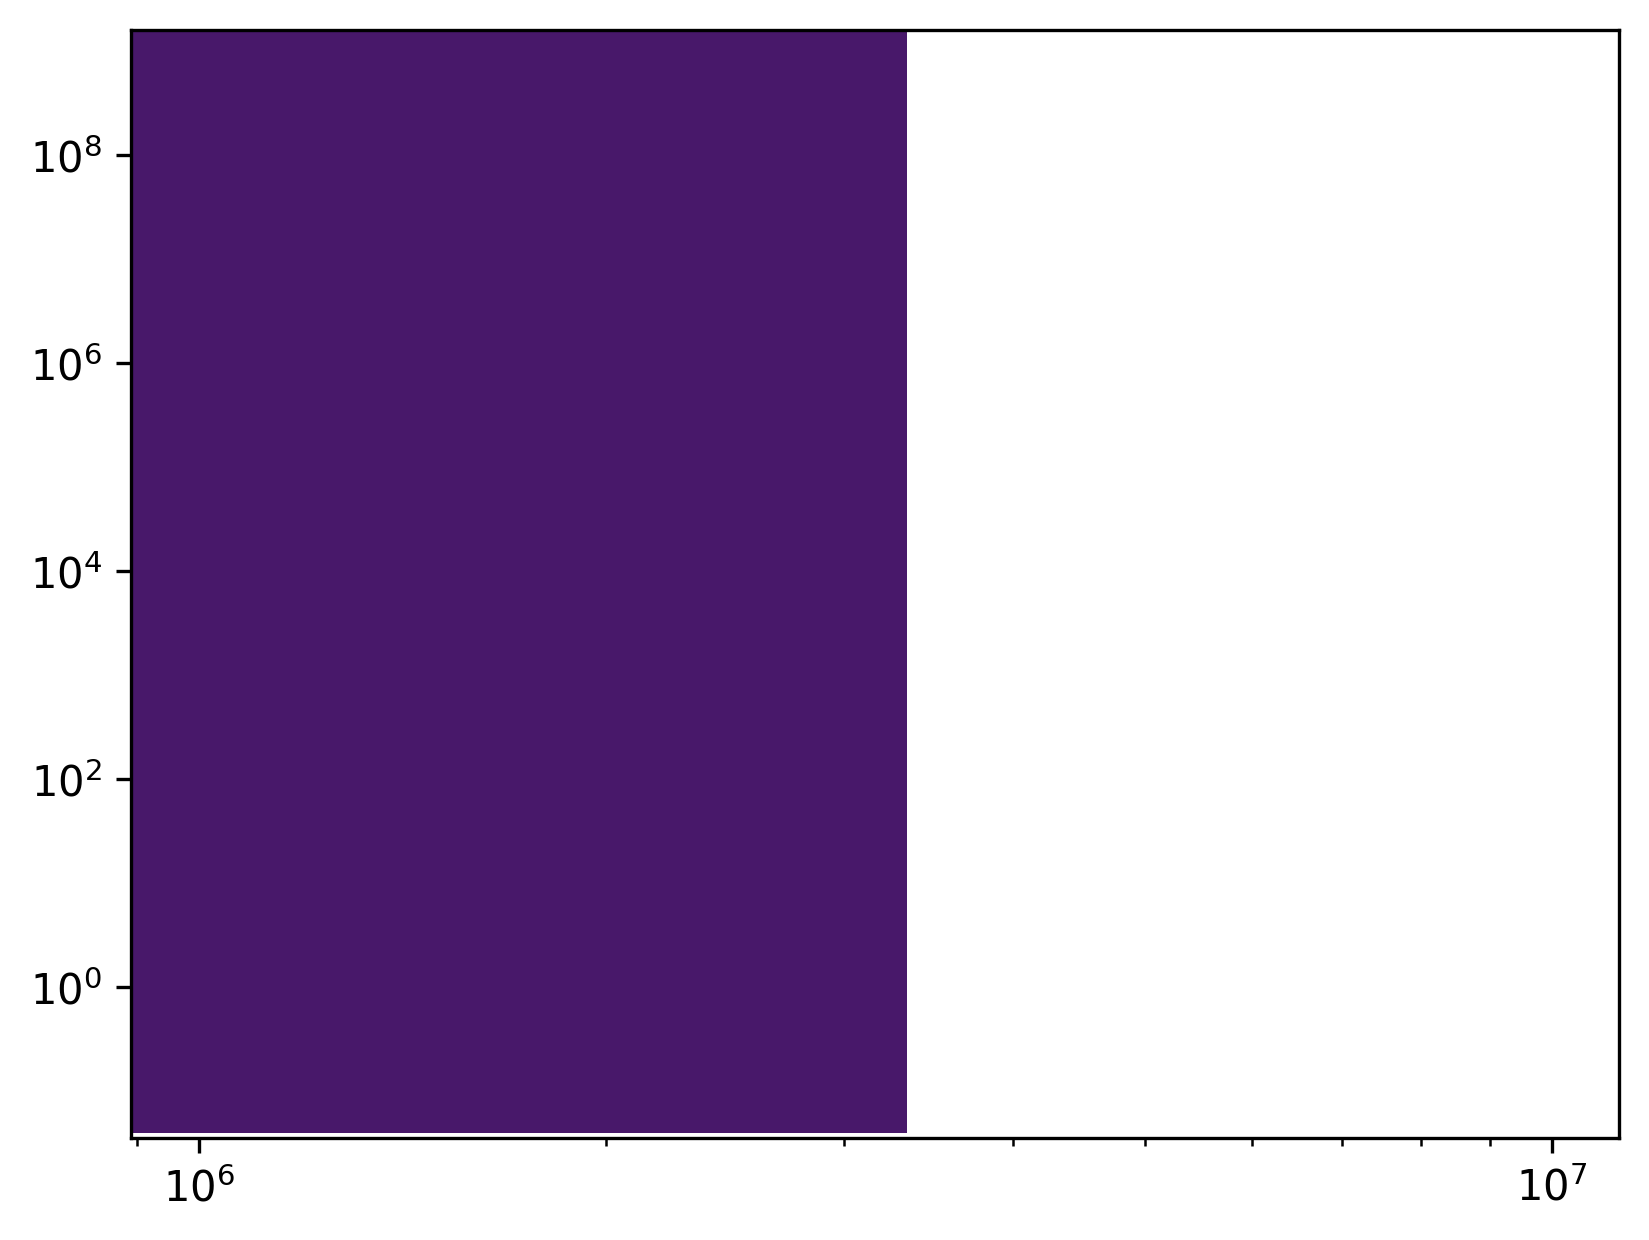

In [46]:
using PyPlot
n = 20
fig, ax = subplots(dpi=300)

ax.contourf((ones(50,1) * x_save')[:,1:n], y_save[:,1:n], u_save[1,:,1:n])

ax.set_xscale("log")
ax.set_yscale("log")

In [19]:
x_save

100-element Array{Float64,1}:
    0.0
    0.16840519741236218
    0.18579719642113568
    0.2292727110479862
    0.33802670466020424
    0.6145606716742156
    1.4087079721248008
    3.3101687870920515
    9.514634410051066
   30.20252246543554
   86.22111776819217
  498.0709616337029
 2675.6293402552183
    ⋮
   -9.158602174309981e33
    2.3058413751758023e34
   -5.72412635894423e34
    1.4411508594855854e35
   -3.5775789743403295e35
    9.00719287178127e35
   -2.2359868589629794e36
    5.629495544866361e36
   -1.3974917868514342e37
    3.5184347155401974e37
   -8.734323667817074e37
    2.1990216972106485e38

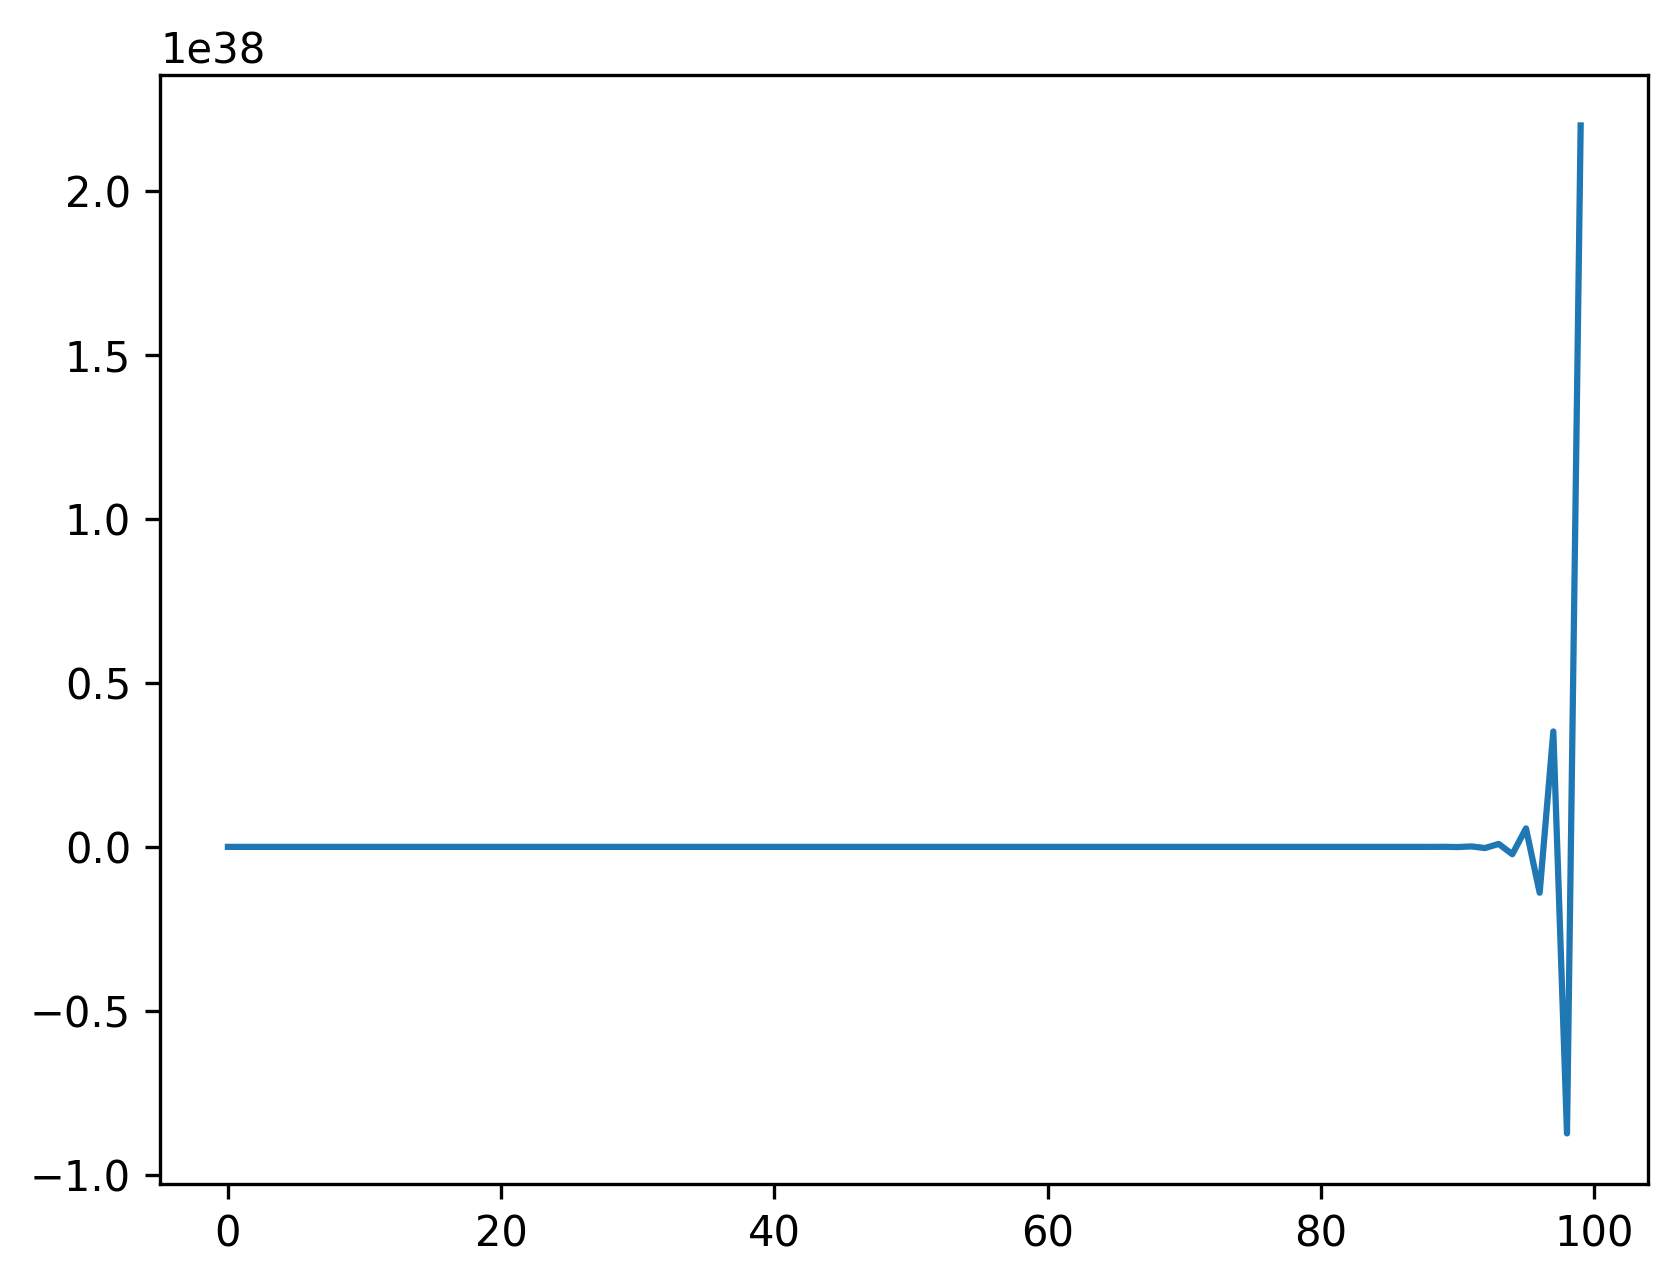

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff8efb264c0>

In [48]:
fig, ax = subplots(dpi=300)

ax.plot(x_save)